In [30]:
import numpy as np
import pandas as pd

from scipy import stats, optimize
import statsmodels.api as sm

import matplotlib.pyplot as plt  
%matplotlib inline  

### Import Data

In [86]:
# check what files are valid for importing
os.listdir()

['Circuit data.csv',
 'Linear weighted data generator.ipynb',
 '.DS_Store',
 'Residuals and Goodness of Fit.ipynb',
 'Monday data.csv',
 '.ipynb_checkpoints']

In [87]:
# assign your file a name to keep things readable
test_file = 'Circuit data.csv'

In [88]:
#import the data as a pandas dataframe (a table)
test_table = pd.read_csv(test_file)

In [89]:
#this shows the first few rows of the dataframe 
test_table.head()

,Current (mA),Voltage (mV),Calculated Resistance (Ohms),Uncertainty (+/- 20% mV)
0,58.2,12900.0,221.65,2580.0
1,77.5,20019.0,258.31,4003.8
2,36.1,7373.0,204.24,1474.6
3,87.5,22439.0,256.45,4487.8
4,52.4,12522.0,238.97,2504.4


In [90]:
#some figures on the table. Varying level of usefulness depending on dataset
test_table.describe()

,Current (mA),Voltage (mV),Calculated Resistance (Ohms),Uncertainty (+/- 20% mV)
count,42.000000,42.000000,42.000000,42.000000
mean,53.419048,10913.357143,197.675714,2182.671429
std,31.374421,7248.583636,44.084306,1449.716727
min,2.300000,455.000000,104.190000,91.000000
25%,23.125000,4465.750000,173.295000,893.150000
50%,51.500000,10264.000000,200.735000,2052.800000
75%,86.650000,18330.750000,221.392500,3666.150000
max,98.200000,25947.000000,291.210000,5189.400000


In [91]:
# gets the column names as a numpy array to allow accessing 
# each name by index
columns = test_table.columns.values
columns

array(['Current (mA)', 'Voltage (mV)', 'Calculated Resistance (Ohms)',
       'Uncertainty (+/- 20% mV)'], dtype=object)

In [92]:
current = test_table[columns[0]].values # column 0 is the first column, voltage
voltage = test_table[columns[1]].values # values converts it to a numpy array

uncertainty = test_table[columns[3]].values

# Fitting Linear Models

Text(0.5,1,'Raw data with no fit')

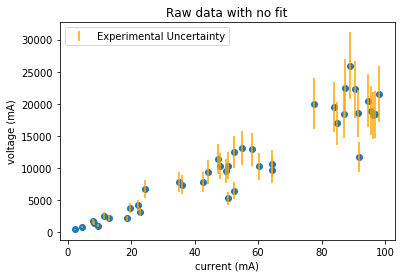

In [127]:
#visualize the data
plt.scatter(current,voltage)

#draw errorbars the size of the "uncertainty" values
plt.errorbar(current,voltage,yerr=uncertainty,fmt='none',label='Experimental Uncertainty',color='orange')


plt.xlabel('current (mA)')
plt.ylabel('voltage (mA)')
plt.legend(loc=2)
plt.title('Raw data with no fit')

## 1) General Approach: Curvefit with specified model (OLS and WLS in SciPy)

The advantage of knowing how to use this is that it extends to any reasonable model you please. This method will work if you need to fit an exponential or gaussian too, for example. All you need to do is create a model as a function of input, like x, and a set of parameters.

ex: model(x,p1,p2,p3,...,pn)

Once this is specified, you tell optimize.curve_fit what your model is, as well as which x and y data it needs to fit to. If your model is any more complicated than a linear model, you should specify a guess for what the optimal parameters are as well to assist the model in converging. We'll look at an example of this later.

In [117]:
#define a linear function, y=mx+b, to fit to data
def linear(x,m,b):
    return m*x + b

In [118]:
#optimize returns the best fit parameters and the covariance matrix for them
#given the model you want to fit (a function you define) and the data

#Ordinary least squares 
params, cov = optimize.curve_fit(linear,xdata=current,ydata=voltage) 
                                                                    

#the diagonal entries of the covariance matrix are the variance
#for each fitted parameter. The square root of them gives their statistical error
error_on_params = np.sqrt(np.diagonal(cov))

params, error_on_params

(array([ 216.61817733, -658.17956687]), array([  12.7020236,  784.4989699]))

You will get back your model parameters and a covariance matrix for your parameters, which you use to determine the statistical error on your parameters.

In [119]:
#this cell is mostly for looks... the same information is available above
print('The slope, m, is '+ str(params[0]) +' +/- ' + str(error_on_params[0]) +'.') 
print('The intercept, b, is ' + str(params[1]) + ' +/- ' + str(error_on_params[1]) + '.')

The slope, m, is 216.618177328 +/- 12.7020235951.
The intercept, b, is -658.179566871 +/- 784.4989699.


Text(0.5,1,'OLS fit with SciPy Curvefit')

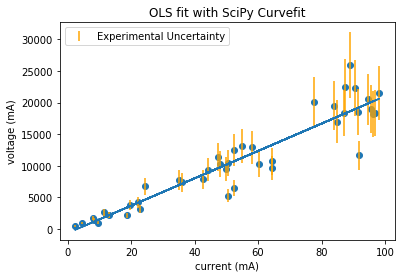

In [129]:
plt.scatter(current,voltage)
plt.errorbar(current,voltage,yerr=uncertainty,fmt='none',label='Experimental Uncertainty',color='orange')

plt.plot(current,linear(current,params[0],params[1]))

plt.xlabel('current (mA)')
plt.ylabel('voltage (mA)')
plt.legend(loc=2)

plt.title('OLS fit with SciPy Curvefit')

#### Curvefit with weights (non-uniform uncertainty -- WLS)

Say we know that our uncertainty is non-uniform. Suppose, for example, that we guess that our uncertainty is 20% of our measured value, as displayed in our original dataset. We need to perform a weighted fit to account for the various error. Optimize's curve_fit allows users to input a vector of uncertainties to perform a weighted fit.

In [120]:
#notice the sigma and absolute sigma in the function below.
#sigma is standard notation for standard deviation, which is more or less
#equivalent to uncertainty in measurements for our purposes

weightedParams, weightedCov = optimize.curve_fit(linear,xdata=current,ydata=voltage,
                                                 sigma=uncertainty,absolute_sigma=True) 

error_on_weightedParams = np.sqrt(np.diagonal(weightedCov))

weightedParams, error_on_weightedParams

(array([ 174.46599815,  -32.98084895]), array([  6.70917002,  80.59222165]))

In [121]:
print('The slope, m, is '+ str(weightedParams[0]) +' +/- ' + str(error_on_weightedParams[0]) +'.') 

print('The intercept, b, is ' + str(weightedParams[1]) + ' +/- ' + str(error_on_weightedParams[1]) + '.')

The slope, m, is 174.465998155 +/- 6.70917002396.
The intercept, b, is -32.9808489475 +/- 80.5922216451.


Text(0.5,1,'WLS fit with SciPy Curvefit')

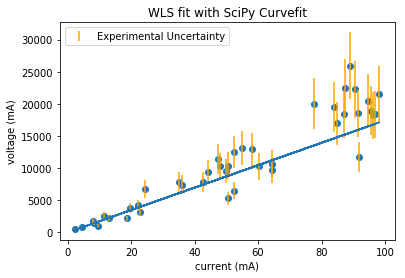

In [130]:
plt.scatter(current,voltage)
plt.errorbar(current,voltage,yerr=uncertainty,fmt='none',label='Experimental Uncertainty',color='orange')

plt.plot(current,linear(current,weightedParams[0],weightedParams[1]))

plt.xlabel('current (mA)')
plt.ylabel('voltage (mA)')
plt.legend(loc=2)

plt.title('WLS fit with SciPy Curvefit')

## 2) Using SciPy Stats' linear regression (OLS in SciPy)

This support a quick fit for data without using weights. The model outputs various information, including the r value, the fitted parameters, and a covariance matrix for calculating statistical error on your parameters.

In [124]:
#the call for this is super easy -- just plug in your x and y values to get a lot of information
sciFit = stats.linregress(current,voltage)
sciFit

LinregressResult(slope=216.61817585904015, intercept=-658.17950850815396, rvalue=0.93759968590199549, pvalue=5.9399646392807262e-20, stderr=12.702022012919146)

In [137]:
print(sciFit.intercept) #best fit intercept
print(sciFit.slope) #best fit intercept

print()
print(np.sqrt(np.diagonal(fitted.cov_params()))) #statistical error on intercept, slope

#r^2 value tells you about how much variation in the data your model accounts for
print('The R^2 value is ' + str(sciFit.rvalue**2)) 

-658.179508508
216.618175859

[ 784.49891697   12.70202201]
The R^2 value is 0.879093171004


Text(0.5,1,'OLS with SciPy Linregress')

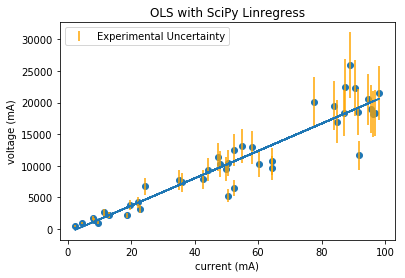

In [131]:
plt.scatter(current,voltage)
plt.errorbar(current,voltage,yerr=uncertainty,fmt='none',label='Experimental Uncertainty',color='orange')

plt.plot(current,linear(current,sciFit.slope,sciFit.intercept))

plt.xlabel('current (mA)')
plt.ylabel('voltage (mA)')
plt.legend(loc=2)

plt.title('OLS with SciPy Linregress')

## 3) Using ordinary least squares with summary (Statsmodels)

In [143]:
x_fit = sm.add_constant(current) #this says to include an intercept when fitting the model

fitted = sm.OLS(voltage,x_fit).fit() #this fits the model to the data. Notice that it is **Y** before X

In [144]:
fitted.params, fitted.cov_params()

(array([-658.17950851,  216.61817586]),
 array([[  6.15438551e+05,  -8.61870196e+03],
        [ -8.61870196e+03,   1.61341363e+02]]))

In [145]:
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     290.8
Date:                Thu, 09 Aug 2018   Prob (F-statistic):           5.94e-20
Time:                        20:23:38   Log-Likelihood:                -388.04
No. Observations:                  42   AIC:                             780.1
Df Residuals:                      40   BIC:                             783.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -658.1795    784.499     -0.839      0.4

Text(0.5,1,'OLS fit with StatsModels')

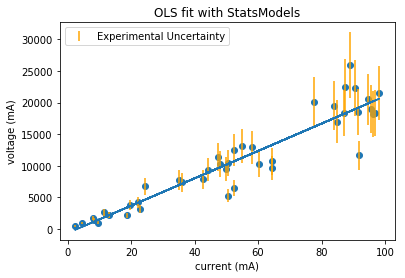

In [146]:
plt.scatter(current,voltage)
plt.errorbar(current,voltage,yerr=uncertainty,fmt='none',label='Experimental Uncertainty',color='orange')

plt.plot(current,linear(current,fitted.params[1],fitted.params[0]))

plt.xlabel('current (mA)')
plt.ylabel('voltage (mA)')
plt.legend(loc=2)

plt.title('OLS fit with StatsModels')

#### Statsmodels with weights

Defining the weight as the inverse square of the uncertainty means that points which are known with a higher degree of certainty are "trusted more" by the model, while points with large degrees of uncertainty don't impact the fit too much.

In [48]:
weight = 1/uncertainty**2

In [49]:
weighted_x_fit = sm.add_constant(current) 

In [147]:
weighted_fit = sm.WLS(voltage, weighted_x_fit, weights=weight).fit()

In [148]:
print(weighted_fit.params)
print()
print(np.sqrt(np.diagonal(weighted_fit.cov_params())))

[ -32.98083995  174.46599787]

[ 110.01289683    9.1583926 ]


In [149]:
print(weighted_fit.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.901
Model:                            WLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     362.9
Date:                Thu, 09 Aug 2018   Prob (F-statistic):           1.14e-21
Time:                        20:24:01   Log-Likelihood:                -379.71
No. Observations:                  42   AIC:                             763.4
Df Residuals:                      40   BIC:                             766.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -32.9808    110.013     -0.300      0.7

Go to https://www.statsmodels.org/dev/examples/notebooks/generated/wls.html for more information and examples of use.

Text(0.5,1,'WLS fit with StatsModels')

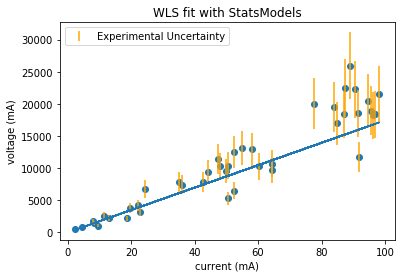

In [151]:
plt.scatter(current,voltage)
plt.errorbar(current,voltage,yerr=uncertainty,fmt='none',label='Experimental Uncertainty',color='orange')

plt.plot(current,linear(current,weighted_fit.params[1],weighted_fit.params[0]))

plt.xlabel('current (mA)')
plt.ylabel('voltage (mA)')
plt.legend(loc=2)

plt.title('WLS fit with StatsModels')

### We've now done the linear fitting problem in 5 different ways - two with weights, three without. 

### Let's compare the results graphically.

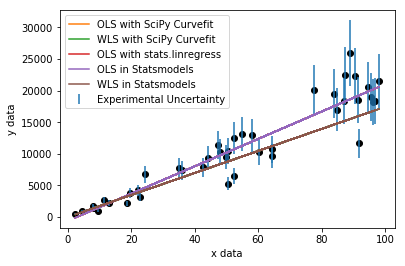

In [153]:
#scatter the raw data and its error
plt.scatter(current,voltage,color='black')
plt.errorbar(current,voltage,yerr=uncertainty,fmt='none',label='Experimental Uncertainty')


#####################################################################################################
#####################       Various fitting methods compared  #######################################
#####################################################################################################

#ordinary least squares with scipy curvefit
plt.plot(current,linear(current,*params),label='OLS with SciPy Curvefit')

#weighted least squares with scipy curvefit
plt.plot(current,linear(current,*weightedParams),label='WLS with SciPy Curvefit')

#ordinary least squares with stats.linregress
plt.plot(current,linear(current,sciFit.slope,sciFit.intercept),label='OLS with stats.linregress')

#ordinary least squares in statsmodels
plt.plot(current,linear(current,fitted.params[1],fitted.params[0]),label='OLS in Statsmodels')

#weighted least squares in statsmodels 
plt.plot(current,linear(current,weighted_fit.params[1],weighted_fit.params[0]),label='WLS in Statsmodels')



#####################################################################################################

#####################################################################################################



plt.xlabel('x data')
plt.ylabel('y data')
plt.legend()

Perhaps unsurprisingly, no matter the package used, the weighted and unweighted methods gave exactly the same solutions.

# Fitting a non-linear function

Suppose we have normally distributed data like below. 

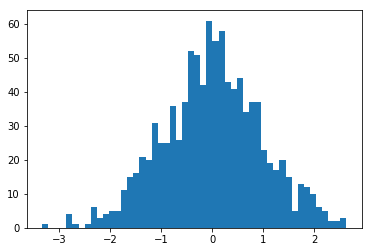

In [156]:
numBins = 50

randomValues = stats.norm.rvs(0,1,1000)
counts, bins, hist = plt.hist(randomValues,bins=numBins)

halfWidths = 0.5*(bins[1] - bins[0])
centers = bins[:-1] + halfWidths

There is no straightforward way to transform this data into a set of linear outputs like with some other datasets, where techniques such as a log transformation may be beneficial. We want to fit a Gaussian curve to this data.

Let's first define what a Gaussian function looks like, which we can use with curve_fit to find the right parameters.

In [158]:
def gaussian(x,a,mu,sigma):
    return a*np.exp(-.5*(x-mu)**2 / (sigma ** 2) )

This says our function takes the form $$f(x;a,\mu,\sigma) = a e^{-\frac{(x-\mu)^{2} }{2\sigma^{2}} }$$

where we wish to find the $a,\mu,\sigma$ that minimize the error between the "best fit" function and the observed data. We will thus invoke the power of curve_fit to optimize for these parameters.

These parameters an amplitude, center, and spread, which we call a, $\mu$, and $\sigma$. We make guesses about what they are to use our fitting algorithm. A reasonable guess for this Gaussian is that the amplitude would be the highest mark, the max amount of counts, the center would be close to the average on the x axis, and the spread would be close to the standard deviation as it normally is for a normalized Gaussian.

Note that these are *guesses* and not exact solutions since this isn't a normalized Gaussian probability density, but a function of the same form.

In [159]:
parameter_guesses = [np.max(counts),np.mean(centers),np.std(centers)]

gaussParams, gaussCov = optimize.curve_fit(f=gaussian,xdata=centers,ydata=counts,p0=parameter_guesses)

gaussParams

array([  5.01571309e+01,   1.00691179e-02,   9.35453158e-01])

The covariance matrix is $\sigma_{i}\sigma_{j}$ where i and j represent the i-th parameter in the given model. For example, the gaussian model has parameters a, mu, and sigma, corresponding to i = {1,2,3}.

The diagonal elements give the square of the uncertainty in your fit parameters,  $[\sigma_{a}^{2}, \sigma_{\mu}^{2},\sigma_{\sigma}^{2}]$. The parameters and their covariance values aren't guaranteed to be well-behaved since the procedure relies on numerical optimization, so be sure to sanity-check your results.

In [162]:
gaussCov

array([[  2.26569375e+00,  -4.48279205e-05,  -2.82622175e-02],
       [ -4.48279205e-05,   1.05000722e-03,   1.89966800e-06],
       [ -2.82622175e-02,   1.89966800e-06,   1.05483195e-03]])

Thus the uncertainties we need can be extracted by taking the square root of the diagonal entries of the covariance matrix just like before in the linear case.

Text(0.5,1,'Gaussian fit with error')

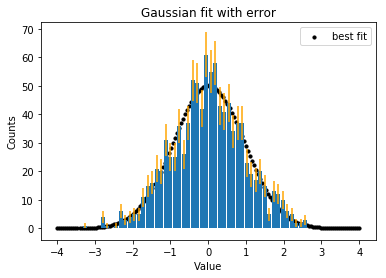

In [163]:
uncertaintyArray = np.sqrt( np.diagonal(gaussCov) )
uncertaintyArray

error= np.sqrt(counts)
plt.errorbar(centers,counts,yerr=error,fmt='none',color='orange')

_,_, hist = plt.hist(randomValues,bins=numBins,rwidth=.8)

xVals = np.linspace(-4,4,150)
plt.scatter(xVals, gaussian(xVals,*gaussParams), color='black',s=10,label='best fit')

plt.legend()
plt.ylabel('Counts')
plt.xlabel('Value')
plt.title('Gaussian fit with error')

# Checking the fit of your model




How can we quantify if our model is a good fit? There are many metrics for "goodness of fit", whether that be R^2, a reduced chi-square test, or otherwise. Since most of these models yield R^2, let's see how we'd calculate the reduced chi-square value. 

First, let's define the chi-square per degree of freedom, or reduced chi-square.

$$\frac{\chi ^{2}}{df} = \frac{1}{N-\nu}\sum_{i=1}^{N} \frac{[y_{i} - f(x_{i};\hat{\theta})]^{2}}{\sigma_{i}^{2}}$$

where $\nu$ is the number of parameters in your model (two for linear models, slope and intercept), $\sigma_{i}$ is the uncertainty in i-th measurement, $y_{i}$ is the i-th measured y value, and $f(x_{i};\hat{\theta})$ is your fitted function evaluated at the i-th x value with your fitted parameters, $\hat{\theta}$. N is, of course, the number of data points you have. Note that $N-\nu$ is what's referred to as the degrees of freedom.

Heuristically speaking, this sum is something like comparing the variance between the fitted values and the measured values with the variance that you're expecting, $\sigma_{i}^{2}$. 

Because of this, a good $\frac{\chi^{2}}{df}$ value is very close to 1. If you underestimate the uncertainty in your measurements, this statistic will be greater than 1 by a significant amount. If you overestimate the uncertainty in your measurements, the statistic will be considerably smaller than 1.

Let's now calculate each piece of this sum for a WLS example and combine them to get the reduced chi square.

In [54]:
x, y, uncertainty

(array([ 58.2,  77.5,  36.1,  87.5,  52.4,  11.4,  89.1,   8. ,   4.5,
         47.5,  97. ,   9.7,  94.6,  50.6,  24.4,  60.4,  18.8,   8.4,
         42.8,  48.1,  35.2,  84. ,  55.1,  19.6,   2.3,  98.2,  13. ,
         64.5,  91.6,  90.4,  44.3,  96.3,  64.5,  22.3,  52.5,  87.2,
         49.8,  91.8,  50.6,  95.7,  22.7,  85. ]),
 array([ 12900.,  20019.,   7373.,  22439.,  12522.,   2605.,  25947.,
          1680.,    873.,  11400.,  18386.,   1011.,  20492.,  10377.,
          6762.,  10261.,   2142.,   1416.,   7830.,  10267.,   7766.,
         19486.,  13135.,   3837.,    455.,  21545.,   2211.,   9678.,
         18514.,  22279.,   9388.,  18198.,  10673.,   4197.,   6461.,
         18375.,   9548.,  11647.,   5272.,  18952.,   3097.,  16945.]),
 array([ 2580. ,  4003.8,  1474.6,  4487.8,  2504.4,   521. ,  5189.4,
          336. ,   174.6,  2280. ,  3677.2,   202.2,  4098.4,  2075.4,
         1352.4,  2052.2,   428.4,   283.2,  1566. ,  2053.4,  1553.2,
         3897.2,  2627.

## Reduced Chi Square Goodness of Fit

In [73]:
best_fit = linear(x,*weightedParams)

In [74]:
numerator = (y - best_fit)**2

In [75]:
denominator = uncertainty**2

In [76]:
dof = len(x) - len(weightedParams)
dof

40

In [77]:
chisquare = np.sum(numerator/denominator)
chisquare

74.535101684878114

In [78]:
reduced_chi2 = chisquare/dof
reduced_chi2

1.8633775421219529

In [79]:
def chi2_pvalue(chi2,dof):
    return 1-stats.chi2.cdf(chi2,df=dof)

In [81]:
chi2_pvalue(chi2=chisquare,dof=dof)

0.00074897731540313206

In [82]:
def reducedChiSquare(observedVector, fittedVector, uncertaintyVector,numberOfParams):
    
    residuals = observedVector - fittedVector
    weightedResiduals = (residuals/uncertaintyVector)**2
    
    DoF = len(observedVector) - numberOfParams
    
    chiSq = np.sum(weightedResiduals)
    
    print('Reduced Chi-Square and p-value: ')
    return chiSq/DoF, chi2_pvalue(chiSq,DoF)

In [84]:
reducedChiSquare(y,best_fit,uncertainty,2)

Reduced Chi-Square and p-value: 


(1.8633775421219529, 0.00074897731540313206)